In [ ]:
!pip install spacy
!spacy download en_core_web_sm
!pip install tensorflow
!pip install nltk
!pip install transformers

In [ ]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.utils import resample
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('Datasets/preposition_dataset.csv', encoding = 'utf8')
df.columns = ['Sentences', 'Label']
df.head()

,Sentences,Label
0,We ran above the beach.,incorrect
1,We ran across the beach.,incorrect
2,We ran after the beach.,incorrect
3,We ran against the beach.,incorrect
4,We ran along the beach.,incorrect


In [ ]:
def sampling(df, samples, shuffle=False):
  csent = df[df["Label"] == "correct"]
  isent  = df[df["Label"] == "incorrect"]
  isent = resample(isent,
              replace=True,
              n_samples=samples,
              random_state=42)
  csent = resample(csent,
              replace=True,
              n_samples=samples,
              random_state=42)
  df = pd.concat([csent, isent])
  if shuffle:
    df = df.sample(frac = 1, random_state = 0)
  df.reset_index(inplace=True)  
  return df  

In [ ]:
def preprocess_extract_features(df):
  stop_words = stopwords.words('english')[:67]
  stop_words.append('He‘s')
  stop_words.append('’m')
  stop_words.append('’s')
  feature = {'verb':[], 'prep':[], 'noun':[], 'label':[]}
  for i, sentence in enumerate(df['Sentences']):
      doc = nlp(sentence)
      for token in doc:
        if token.pos_ == 'ADP':
            verb = token.head.text
            noun = str()
            for child in token.children :
                if child.pos_ == 'NOUN':
                    noun = child.text  
            prep = token.text
            label = df['Label'][i]
            if verb in stop_words or noun in stop_words or prep in stop_words :
              continue     
            feature['verb'].append(verb)
            feature['noun'].append(noun)
            feature['prep'].append(prep)
            feature['label'].append(label)
  df_features = pd.DataFrame.from_dict(feature)
  return df_features

In [ ]:
df = sampling(df, 2000, True)

In [ ]:
df_features = preprocess_extract_features(df)
print(df_features.head(10), '\n',df_features.isnull().any())

      verb     prep    noun      label
0  playing       in    yard    correct
1   rolled    under   couch    correct
2     read   During  flight    correct
3    front       of   house    correct
4     fell      off  ladder    correct
5  perched       on  branch    correct
6  flowing    under  bridge  incorrect
7  climbed       up    tree  incorrect
8     flew    below   fence  incorrect
9   flowed  beneath  bridge  incorrect 
 verb     False
prep     False
noun     False
label    False
dtype: bool


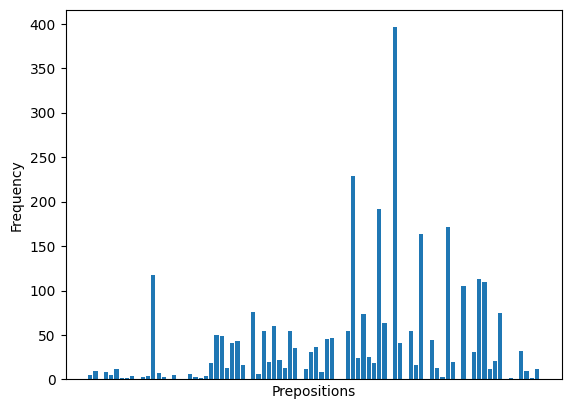

In [ ]:
import matplotlib.pyplot as plt
group = df_features.groupby('prep').groups
x=[]
y=[]
for key in group:
  x.append(key)
  y.append(len(group[key]))
plt.bar(x, y, align='center')
plt.rcParams['figure.figsize'] = [10, 10]
plt.xticks([], fontsize=5)
plt.xlabel('Prepositions')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
def encode_data(df_freq):
  df_freq['verb'] = np.array(tokenizer.batch_encode_plus(list(df_freq['verb']), return_attention_mask = False, padding = 'max_length',max_length=1, truncation = True, add_special_tokens = False )['input_ids'])
  df_freq['noun'] = np.array(tokenizer.batch_encode_plus(list(df_freq['noun']), return_attention_mask = False, padding = 'max_length',max_length=1, truncation = True, add_special_tokens = False )['input_ids'])
  df_freq['prep'] = np.array(tokenizer.batch_encode_plus(list(df_freq['prep']), return_attention_mask = False, padding = 'max_length',max_length=1, truncation = True, add_special_tokens = False )['input_ids'])
  y = np.array(df_freq['label'].map({'correct': 0, 'incorrect': 1}))
  X = np.array(df_freq.drop(['label'], axis=1))
  return X,y
X, y= encode_data(df_features) 
X.shape, y.shape

((3097, 3), (3097,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X.shape, X_train.shape, X_test.shape

((3097, 3), (2167, 3), (930, 3))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 200, criterion = 'gini')

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.7935483870967742

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index=df_features.drop(['label'], axis=1).columns).sort_values(ascending = False)
feature_imp

noun    0.352649
verb    0.336387
prep    0.310964
dtype: float64

In [ ]:
#Test Cases 
sent = ['I met Donna across a party on Friday night', 'I don’t usually feel tired in the morning.']
d = pd.DataFrame({'Sentences':sent, 'Label':['incorrect', 'correct']})
d = preprocess_extract_features(d)
d['label'][1] = 'correct'
print(d)
a, b = encode_data(d)

    verb    prep     noun      label
0    met  across    party  incorrect
1    met      on    night    correct
2  tired      in  morning    correct


In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix:\n',confusion_matrix(b,clf.predict(a)))
print('Accuracy:',accuracy_score(b,clf.predict(a)))

Confusion Matrix:
 [[2 0]
 [0 1]]
Accuracy: 1.0
